## Spark ML : Linear Regression Example1


### Concepts :

* Creating RDD using SparkContext
* Providing schema to create a DataFrame from an RDD
* Performing basic data analysis using Spark SQL
* Using Spark ML to perform train a linear regression model

### Input Dataset :

* California Housing Dataset, housing prices per 'blocks' of census. Each row in the dataset corresponds to a block group. A block corresponds to a group of citizens that live in a geographically compact area

### Objective :

* Build a model that is able to predict the median house price

### Dataset Details:

Features : 

* Latitude 
* Longitude
* Housing median age : median age of the people that belong to a block group 
* Total rooms : total nb of rooms in the houses of the block group 
* Total bedrooms : total nb of bedrooms in the houses of the block group
* Population : nb of inhabitants of a block group 
* Households : units of houses and their occupants per block group 
* Median income : median income of people that belong to a block group 

Target :

* Median house value 

### Overall Workflow

1. Load Data
2. Inspect Data
3. Preprocess Data
4. Create Model
5. Make Predictions
6. Evaluate how good are our predictions

In [34]:
import os
my_home=os.environ['HOME']
dataset_path=my_home+"/spark-course/data/housing_data/"
outputs_path=my_home

In [35]:
import os
print(os.environ['SPARK_HOME'])
print(os.environ['PYSPARK_PYTHON'])

/usr/hdp/current/spark2-client
/usr/bin/python3.6


In [36]:
import findspark
findspark.init()
import pyspark

In [37]:
# Create a SparkSession and specify configuration
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Lab5-ML-LinearRegression-Example") \
    .getOrCreate()

### Data Loading

Direct data inspection shows that the input data has no header.
There are several ways this can be tacked , I provide here only 2 examples on how to provide the schema, to construc the data frame
  * option 1 : use the Row object,construct a DataFrame by creating Row objects (remember a DataFrame is a Dataset[Row]
  * option 2 : infer the schema from the data and add a header
  * option 3 : manually provide a schema using the StructType construct
  * there are possible other options , even simpler ... provide it yourself 

In [38]:
def readLine(line):
    """ Parse a line from the input data
    Args:
        line (str): a line (row) of the input data file
    Returns:
        Row : row object containin the parsed elements from the line
        Note we are adding schema by directly transforming the str into double types
    """
    
    parts=re.split(",", line)
   
    # Read in each feature PLUS THE TARGET
    lat = parts[0]
    lon = parts[1]
    age = parts[2]
    trm = parts[3]
    tbr = parts[4]
    pop = parts[5]
    hou = parts[6]
    inc = parts[7]
    val = parts[8]
        
    return Row(
                latitude=float(lat),
                longitude=float(lon),
                median_housing_age=float(age),
                total_rooms=float(trm),
                total_bedrooms=float(tbr),
                population=float(pop),
                households=float(hou),
                median_income=float(inc),
                median_value=float(val)
           )

In [39]:
# ---------
# Option 1 : use SparkContext and a function to map each line to a Row object
# ---------
from pyspark.sql import Row
import re
sc=spark.sparkContext
rdd = sc.textFile("file://"+dataset_path+"*.data")
#
df = rdd \
        .map(lambda line: readLine(line)) \
        .toDF()

In [40]:
df.show(10)

+----------+--------+---------+------------------+-------------+------------+----------+--------------+-----------+
|households|latitude|longitude|median_housing_age|median_income|median_value|population|total_bedrooms|total_rooms|
+----------+--------+---------+------------------+-------------+------------+----------+--------------+-----------+
|     126.0| -122.23|    37.88|              41.0|       8.3252|    452600.0|     322.0|         129.0|      880.0|
|    1138.0| -122.22|    37.86|              21.0|       8.3014|    358500.0|    2401.0|        1106.0|     7099.0|
|     177.0| -122.24|    37.85|              52.0|       7.2574|    352100.0|     496.0|         190.0|     1467.0|
|     219.0| -122.25|    37.85|              52.0|       5.6431|    341300.0|     558.0|         235.0|     1274.0|
|     259.0| -122.25|    37.85|              52.0|       3.8462|    342200.0|     565.0|         280.0|     1627.0|
|     193.0| -122.25|    37.85|              52.0|       4.0368|    2697

In [41]:
df.printSchema()

root
 |-- households: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- median_housing_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_value: double (nullable = true)
 |-- population: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- total_rooms: double (nullable = true)



In [42]:
# ---------
# Option 2 :  use SparkSession and infer schema, then add a header
# ---------

df2 = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"*.data")
    
features=[ "latitude","longitude","median_housing_age", \
            "total_rooms","total_bedrooms","population", \
            "households","median_income"]
target=["median_value"]

fieldnames=features+target

rawnames=df2.schema.names

# Create a small function
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

df2=updateColNames(df2,rawnames,fieldnames)

df2.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- median_housing_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_value: double (nullable = true)



In [43]:
# ---------
# Option 3 :  manually provide a Schema
# ---------

# from pyspark.sql.types import *
# fieldnames=[ "latitude","longitude","median_housing_age", \
#            "total_rooms","total_bedrooms","population", \
#            "households","median_income","median_value"]
# def applySchema(x,fieldnames):
#      fields = [StructField(field_name, DoubleType(), True) for field_name in fieldnames]
#      schema = StructType(fields)
#      return x
# 
# features = rdd \
#            .map(lambda line: line.split(",")) \
#            .map(lambda x : applySchema(x,fieldnames))

In [44]:
# Create a table for SQL access
df.registerTempTable("houses")

### Data Inspection

In [45]:
# Records
df.count()

20640

In [46]:
# Summary statistics on the selected (or full) set of fields of the dataframe
# ( Remember the total rooms are PER GROPU BLOCK of census , not per house ..., obviously)
df.select('total_rooms','total_bedrooms','median_income','population').describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|       total_rooms|   total_bedrooms|     median_income|        population|
+-------+------------------+-----------------+------------------+------------------+
|  count|             20640|            20640|             20640|             20640|
|   mean|2635.7630813953488|537.8980135658915|3.8706710029070246|1425.4767441860465|
| stddev|2181.6152515827944| 421.247905943133| 1.899821717945263|  1132.46212176534|
|    min|               2.0|              1.0|            0.4999|               3.0|
|    max|           39320.0|           6445.0|           15.0001|           35682.0|
+-------+------------------+-----------------+------------------+------------------+



### Worth Noting Here

See here that the **standard deviation is in almost all cases of the order of the mean value**

**Meaning there is a large spread in our data** and pointing to the fact that we will need to somehow **normalize our data**

### Look for Correlations

In [47]:
# Create a small function
# that computes the correlation of each column against the target
# Computes Pearson Correlation Coefficient between the two columns
def computeCorrelation(df,targetColumnName):
    from pyspark.ml.stat import Correlation
    for col in df.columns:
        r=df.stat.corr(col,targetColumnName)
        print("Pearson correlation : %s %s %f \n" %(col,targetColumnName,r))

In [48]:
# THERE SEEMS TO BE A SPARK INSTALLATION PROBLEM WITH TEH STATS LIB
# FIXME !
# computeCorrelation(df, 'median_value')

### Data Visualization


You would typically take a sub sample (no replacement here) from the data JUST for plotting purposes.

Sampling with or without replacement has important statistical differences ( selection bias ), but we are jsut plotting

Usefull explanation of sample with or without replacement implications here:

https://www.ma.utexas.edu/users/parker/sampling/repl.htm

Linear Relationships (plotting):
https://seaborn.pydata.org/tutorial/regression.html

residuals : 41793.849202


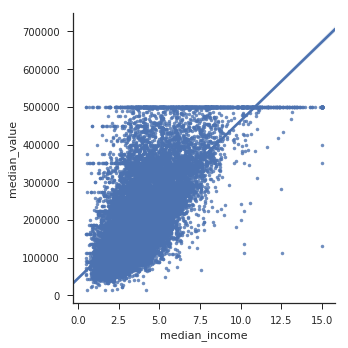

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lmplot("median_income", "median_value", data=df.toPandas(), fit_reg=True, markers=".")
#
# SIMPLE , least squares fit
# 
# IMPORTANT NOTE : you will -always- want to scale your data
# before doing this below , is there just for simple demo purposes
#
import numpy as np
resi,rank,sing,rcond,c=np.polyfit(df.toPandas()['median_income'], df.toPandas()['median_value'], 1,full=True)
print('residuals : %f' % resi[0])

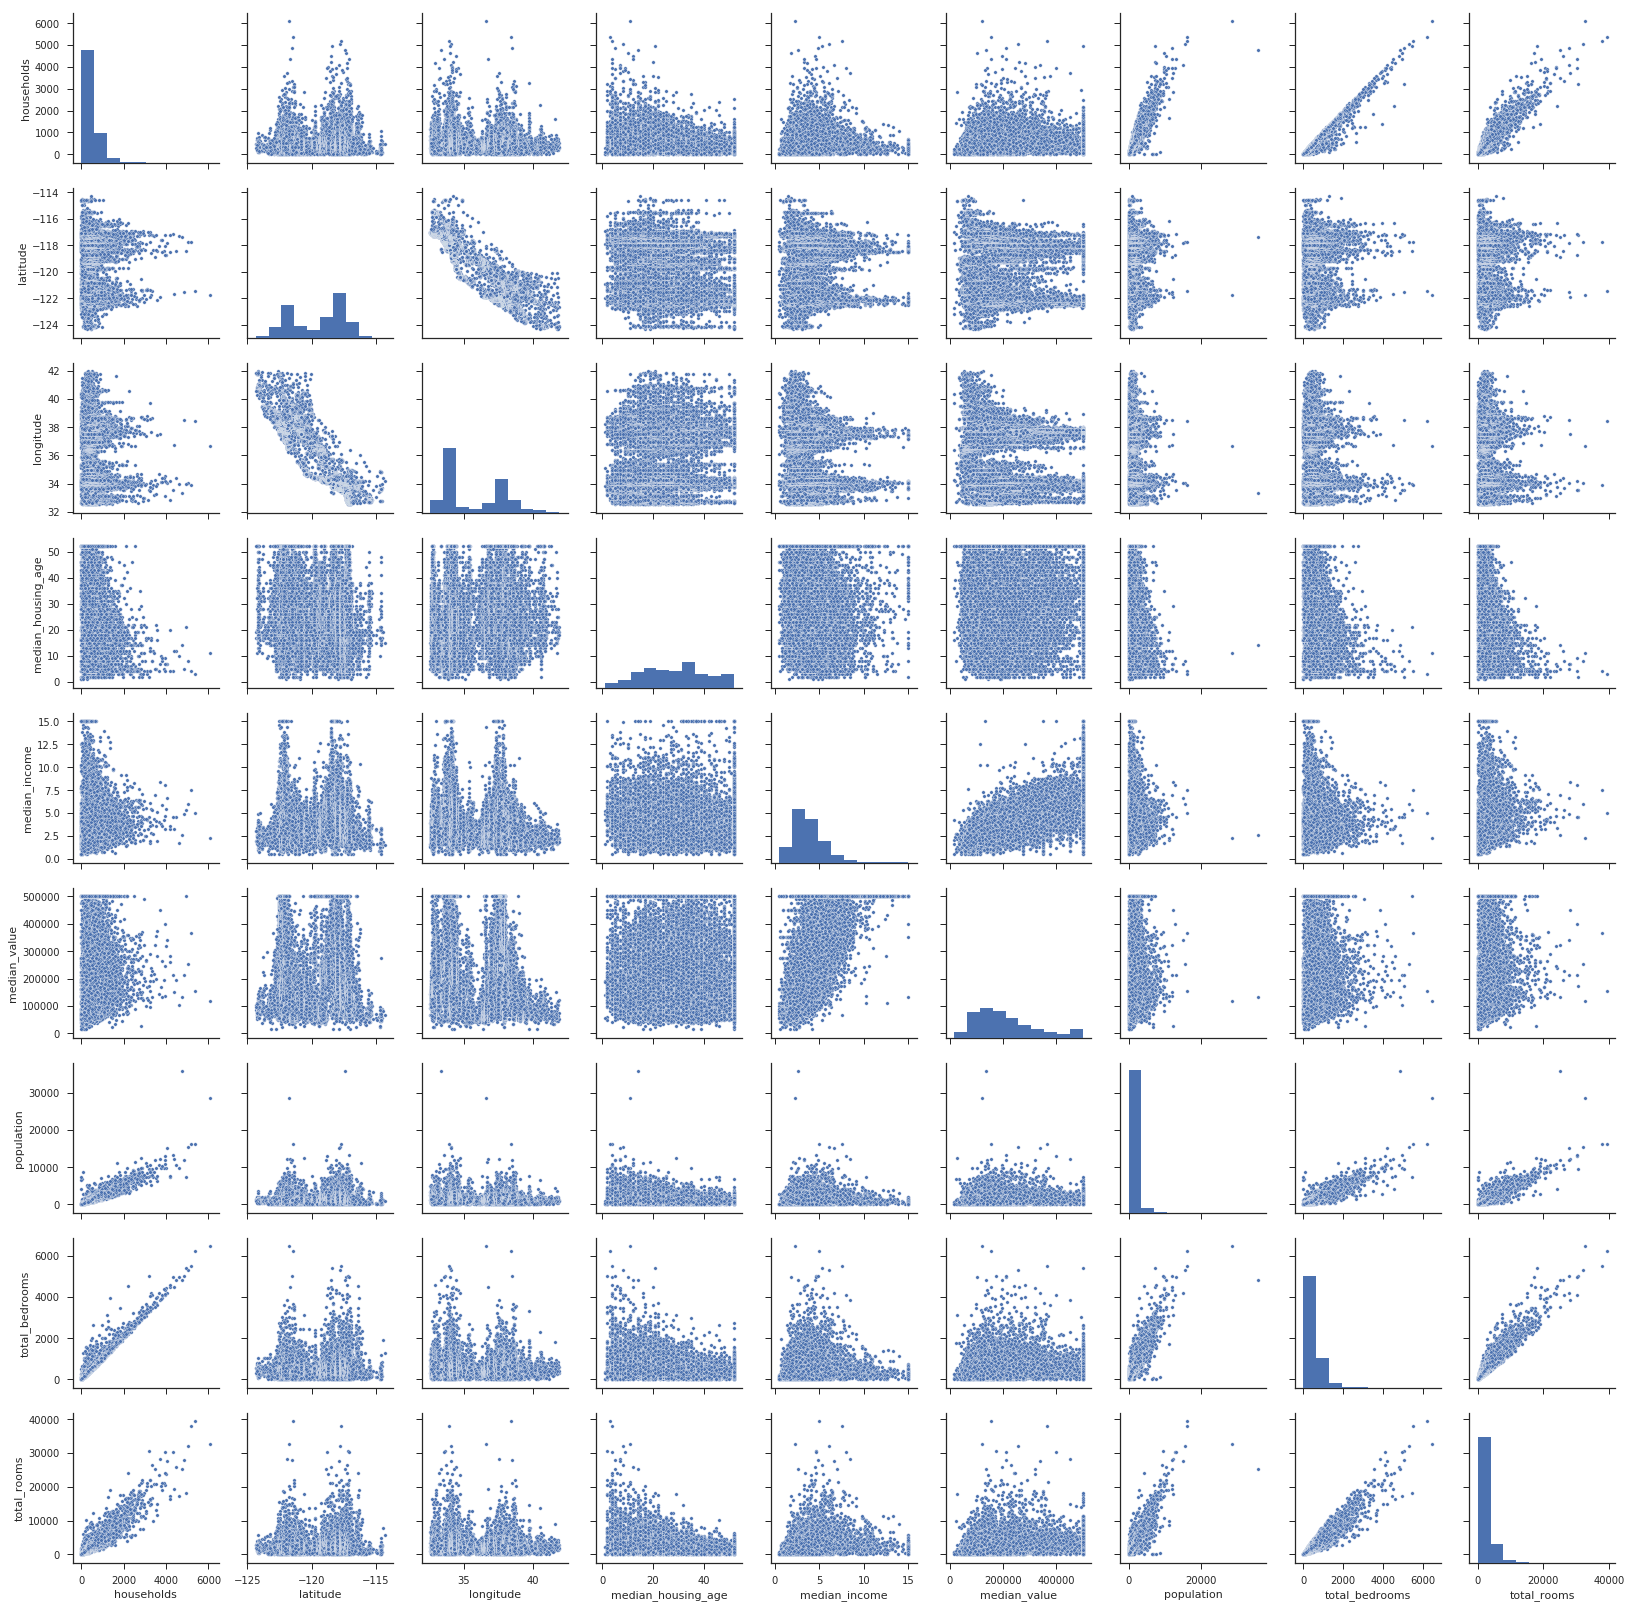

In [64]:
import seaborn as sns
sns.set(style="ticks", color_codes=True )
sns.pairplot(df.toPandas(), markers=".")
plt.show()

### Data Preprocessing

**Adjust our target variable**

As we said before is recommended to scale the target variable prior to model creation. Doing this will avoid problems during the model creation and predictions computation, due to large values and possible outliers in the data. This also eases the scaling process later.

**Add some 'new' features** to our existing set of features.
This are qualitative information that could help us in predicting the median_value of a house

1. Rooms per household :  number of rooms in households per block group
2. Population per household :  how many people live in households per block group 
3. Bedrooms per room : gives you an idea about how many rooms are bedrooms per block group

In [65]:
# Adjust the values of `median_value`
# We will express the median_value in units of 100
from pyspark.sql.functions import *
df = df.withColumn("median_value", col("median_value")/100000)

In [66]:
from pyspark.sql.functions import *
# 1.
roomsPerHousehold = df['total_rooms']/df['households']

# 2.
populationPerHousehold = df['population']/df['households']

# 3.
bedroomsPerRoom = df['total_bedrooms']/df['total_rooms']

# Add the new columns to `df`
df = df.withColumn("roomsPerHousehold",roomsPerHousehold) \
       .withColumn("populationPerHousehold",populationPerHousehold) \
       .withColumn("bedroomsPerRoom", bedroomsPerRoom)
   
# Check what is the output
df.first()

Row(households=126.0, latitude=-122.23, longitude=37.88, median_housing_age=41.0, median_income=8.3252, median_value=4.526, population=322.0, total_bedrooms=129.0, total_rooms=880.0, roomsPerHousehold=6.984126984126984, populationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908)

In [68]:
# Re-order and select columns
df = df.select('median_value',
              'total_bedrooms', 
              'population', 
              'households', 
              'median_income', 
              'roomsPerHousehold', 
              'populationPerHousehold', 
              'bedroomsPerRoom'
              )

In [71]:
from pyspark.ml.linalg import DenseVector

# We need to transform each row of feature into a vector ( a continous space of values )
# for the algorithm : in particular a DenseVector
# The density of a vector is defined by the number of empty values it has. 
# lesser empty values, bigger density of the vector

# A full view of data types in RDD based API ;
# https://spark.apache.org/docs/2.2.0/mllib-data-types.html


# Define the input_data 
# The median value (row[0]) is our target variable ( the label )
# The rest of the values row[1:] our our features
data = df.rdd.map(lambda row: (row[0], DenseVector(row[1:])))

# Replace df with the new DataFrame
df = spark.createDataFrame(data, ["label", "features"])

In [72]:
df.toPandas().head(4)

Py4JJavaError: An error occurred while calling o649.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 68.0 failed 1 times, most recent failure: Lost task 0.0 in stage 68.0 (TID 68, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 171, in main
    process()
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 166, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in toInternal
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in <genexpr>
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 436, in toInternal
    return self.dataType.toInternal(obj)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 654, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1928)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1941)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1954)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1968)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:278)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2768)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2765)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withNewExecutionId(Dataset.scala:2788)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2765)
	at sun.reflect.GeneratedMethodAccessor60.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 171, in main
    process()
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 166, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in toInternal
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in <genexpr>
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 436, in toInternal
    return self.dataType.toInternal(obj)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 654, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


### Feature Scaling ( Standarization )

At this stage we can see that features are not scaled.

Scaling features is a very common pre-processing step and can improve the convergence rate during the optimization process, and also prevents against features with very large variances exerting an overly large influence during model training.

In [73]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df)

# Transform the data in df using the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.take(2)

Py4JJavaError: An error occurred while calling o693.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 69.0 failed 1 times, most recent failure: Lost task 0.0 in stage 69.0 (TID 69, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 171, in main
    process()
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 166, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in toInternal
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in <genexpr>
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 436, in toInternal
    return self.dataType.toInternal(obj)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 654, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1928)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1991)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1008)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1128)
	at org.apache.spark.mllib.feature.StandardScaler.fit(StandardScaler.scala:57)
	at org.apache.spark.ml.feature.StandardScaler.fit(StandardScaler.scala:117)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 171, in main
    process()
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/worker.py", line 166, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in toInternal
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/pyspark/sql/types.py", line 576, in <genexpr>
    return tuple(f.toInternal(v) for f, v in zip(self.fields, obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 436, in toInternal
    return self.dataType.toInternal(obj)
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/sql/types.py", line 654, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/usr/hdp/current/spark2-client/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [25]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())

Training records : 16479
Test records : 4161 


### Model Creation

In [26]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="label", maxIter=10, elasticNetParam=0.8)

# Fit the data to the models
linearModelA = lr.fit(train_data,{lr.regParam:0.1})
linearModelB = lr.fit(train_data,{lr.regParam:0.3})
linearModelC = lr.fit(train_data,{lr.regParam:0.6})
# Generate predictions for models
predictedA = linearModelA.transform(test_data)
predictedB = linearModelB.transform(test_data)
predictedC = linearModelC.transform(test_data)

### Model Evaluation

In [27]:
predictedB.toPandas().head(10)

,label,features,features_scaled,prediction
0,0.14999,"[28.0, 18.0, 8.0, 0.536, 12.25, 2.25, 0.285714...","[0.0664691731518777, 0.015894571353910432, 0.0...",1.134012
1,0.14999,"[73.0, 85.0, 38.0, 1.6607, 6.7105263157894735,...","[0.1732946300031097, 0.0750576980601326, 0.099...",1.448502
2,0.14999,"[239.0, 490.0, 164.0, 2.1, 3.774390243902439, ...","[0.567361870832099, 0.43268555352311733, 0.428...",1.571340
3,0.28300,"[3114.0, 12427.0, 2826.0, 2.7377, 6.2767162066...","[7.392321614105256, 10.973435456391385, 7.3915...",1.749654
4,0.36600,"[199.0, 567.0, 204.0, 0.9288, 4.28921568627451...","[0.4724059091865594, 0.5006789976481786, 0.533...",1.243847
5,0.36700,"[238.0, 425.0, 157.0, 1.0486, 5.97452229299363...","[0.5649879717909605, 0.37528849030066297, 0.41...",1.277346
6,0.37500,"[650.0, 5723.0, 615.0, 2.1652, 3.7512195121951...","[1.543034376740018, 5.0535906588016335, 1.6085...",1.589571
7,0.38800,"[263.0, 1274.0, 241.0, 1.9417, 4.9502074688796...","[0.6243354478194227, 1.1249824391601049, 0.630...",1.527076
8,0.40000,"[199.0, 246.0, 102.0, 2.5391, 7.91176470588235...","[0.4724059091865594, 0.21722580850344256, 0.26...",1.694121
9,0.40400,"[1636.0, 3431.0, 1329.0, 3.4145, 5.96087283671...","[3.8836988313025684, 3.029681906403705, 3.4760...",1.938902


In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')
scoreA = evaluator.evaluate(predictedA)
scoreB = evaluator.evaluate(predictedB)
scoreC = evaluator.evaluate(predictedC)
print('Score for model A is : %f' % scoreA )
print('Score for model B is : %f' % scoreB )
print('Score for model C is : %f' % scoreC )

Score for model A is : 0.877272
Score for model B is : 0.886764
Score for model C is : 0.886764


In [29]:
# Get the RMSE ( standard deviation of the residuals ) residual = predicted - observed
# It indicates the absolute fit of the model to the data ,
# or how close the observed data points are to the model's predicted values
# The smaller an RMSE value, the closer predicted and observed values are.
linearModelA.summary.rootMeanSquaredError

0.8225056351690899

In [30]:
# Get the R2
# The R2 (coefficient of determination) is a measure 
# of the dispersion of the data with respect to fitted regression line, a relative measurement,
# and varies between 0-100% 
# 0% indicates that the model explains none of the variability of the response data around its mean, 
# and 100% indicates the opposite: it explains all the variability. 
# In gemneral , the higher the R-squared, the better the model fits your data.
linearModelA.summary.r2

0.491781794269729

In [74]:
spark.stop()